In [42]:
import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Ridge

import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
import seaborn as sns
sns.set_style("whitegrid")

In [43]:
def r2_score(y,y_hat):
    ratio = np.sum((y-y_hat)**2) / np.sum((y-np.mean(y))**2)
    r_square = 1 - ratio
    return r_square

In [66]:
# 讀取資料
data = pd.read_csv(r'C:\Users\GN1504301\Desktop\競賽資料-utf8\競賽資料-utf8\租屋資訊trainset.csv',encoding='utf-8')
test_set = pd.read_csv(r'C:\Users\GN1504301\Desktop\競賽資料-utf8\競賽資料-utf8\租屋資訊testset.csv',encoding='big5')

In [45]:
data['floor_ratio'] = data['floor'] / data['allfloor']
data['cp_value'] = data['price'] / data['area']

data['region_cp_mean'] = data.groupby('sectionname')['cp_value'].transform('mean')
data['station_cp_mean'] = data.groupby('min_station_name')['cp_value'].transform('mean')

data['ground_space'] = 0
data['ground_space'][data['floor'] == 0] = 1

C:\Users\GN1504301\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


創造新變數

floor_ratio : 租屋的樓層比，值在0-1之間，想法是值越靠近1時租金會越便宜（爬越多樓梯？）<br>
cp_value : 每坪租金，用來做outlier值篩選 <br>
region_cp_mean : 同一行政區下的平均cp_value，用來衡量不同行政區的繁華程度 <br>
station_cp_mean : 同一捷運站下的平均cp_value，用來衡量不同捷運站的繁華程度(此變數較不穩定) <br>

In [46]:
def mapping(x):
    if x == '分租套房':
        return '1房0廳1衛'
    if x == '獨立套房':
        return '1房0廳1衛'
    if x == '雅房':
        return '1房0廳0衛'
    if x == '其他':
        return '0房0廳0衛'

In [47]:
data['layout2'] = data['kind_name'].apply(mapping)
data['layout_total'] = data['layout'].fillna('') + data['layout2'].fillna('')
data['rooms'] = data['layout_total'].str.split('房').str[0]
data['way'] = data['layout_total'].str.split('廳').str[1]
data['way'] = data['way'].str.split('衛').str[0]

創造新變數

rooms : 租屋房間數，假設其他類為0，套房類為1 <br>
way : 租屋衛浴數，假設其他與雅房類為0，套房類為1 <br>

In [48]:
data = data.query('room != 99').reset_index(drop = True)
data = data.query('cp_value < 7340 & cp_value > 250').reset_index(drop = True)
data = data.query('floor_ratio <=1').reset_index(drop = True)

移除資料

1. 99房移除 (開放式空間 + 車位) <br>
2. 極端cp_value的租屋移除 <br>
   極端值的定義為 mean(cp_value) + 3*std(cp_value)
3. floor_ratio > 1的移除 <br>

In [49]:
# 創造 kind_name & sectionname虛擬變數
kind_dum = pd.get_dummies(data.kind_name)
sect_dum = pd.get_dummies(data.sectionname)
dumms = pd.concat([kind_dum,sect_dum],axis = 1) 
data = pd.concat([data,dumms],axis = 1)

In [50]:
# 將living欄資訊轉為虛擬變數
living = pd.Series(data.living)
living.fillna('0',inplace=True)
liv_list = ['depart', 'advstore', 'market', 'night', 'park', 'school', 'hospital']

liv2_list = []
for i in living:
    liv_dict = OrderedDict()
    for j in i.split(','):
        '''
        if j not in liv_list:
            liv_list.append(j)
        '''
        if j in liv_list:
            liv_dict['%s' %j] = 1
    liv2_list.append(liv_dict)

liv_frame = pd.DataFrame(liv2_list)
liv_frame.fillna('0',inplace=True)

In [51]:
# 將condition欄資訊轉為虛擬變數
condition = pd.Series(data.condition)
condition.fillna('0',inplace=True)
cond_list = ['tv','icebox','cold','washer','hotwater','four','broadband','landpost','pet','cook','trabus','balcony_0',
 'lease','bed','wardrobe','sofa','bookTable','chair','balcony_1','naturalgas','cartplace','lift','boy','isleastrent',
 'girl','teaTable','bookshelf','dinette','watermemachine','gasstove']

cond2_list = []
for i in condition:
    cond_dict = OrderedDict()
    for j in i.split(','):
        '''
        if j not in cond_list:
            cond_list.append(j)
        '''
        if j in cond_list:
            cond_dict['%s' %j] = 1
    cond2_list.append(cond_dict)

cond_frame = pd.DataFrame(cond2_list)
cond_frame.fillna('0',inplace=True)

In [52]:
dum_frame = pd.concat([liv_frame,cond_frame],axis = 1)
dum_frame.describe()

,depart,advstore,market,night,park,school,hospital,tv,icebox,cold,...,balcony_1,lift,boy,isleastrent,girl,teaTable,bookshelf,dinette,watermemachine,gasstove
count,9146,9146.0,9146.0,9146,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,...,9146.0,9146,9146,9146,9146,9146,9146,9146,9146,9146
unique,2,2.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2,2,2,2,2,2,2,2,2
top,0,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0,0,0,0,0,0,0,0,0
freq,5094,6324.0,5209.0,5360,6083.0,5861.0,4697.0,5854.0,6728.0,8378.0,...,5857.0,5184,9025,9081,8561,9143,9142,9145,9143,9145


從上面表格可看出有些變數呈現一面倒的狀況，例如dinette,gasstove,teaTable等等，這些變數的預測能力應該很糟糕

In [53]:
full = pd.concat([data,dum_frame],axis = 1)

In [54]:
# 刪除無用的欄位
col2drop = ['houseage','id','living','condition','address_img_title','lat','lng','loc_type','min_station_name','min_park_name',
            'allfloor','unit','regionname','kind_name','fulladdress','layout','address','sectionname','room'
           ,'watermemachine','gasstove','dinette','teaTable','bookshelf','cp_value','layout2','layout_total'] #
cols = [col for col in full.columns if col not in col2drop]
full_data = full[cols]

In [55]:
full_data.head()

,area,price,floor,min_station,min_park,floor_ratio,region_cp_mean,station_cp_mean,ground_space,rooms,...,sofa,bookTable,chair,naturalgas,cartplace,balcony_1,lift,boy,isleastrent,girl
0,15.0,16500.0,7,466.615329,128.302422,0.583333,1680.532380,1647.829599,0,1,...,1,1,1,0,0,0,0,0,0,0
1,6.0,7800.0,4,491.912541,203.220846,0.800000,1326.795479,1474.260730,0,1,...,0,1,1,0,0,0,0,0,0,0
2,45.0,45000.0,10,1299.338389,99.717441,0.714286,1279.257306,1262.717756,0,3,...,1,1,1,1,1,1,0,0,0,0
3,9.0,18000.0,14,523.118458,183.753753,0.933333,1680.532380,1533.820515,0,1,...,1,1,1,0,0,0,0,0,0,0
4,15.1,16000.0,5,150.628808,211.178627,0.500000,1537.655015,1413.802897,0,1,...,1,1,1,1,1,1,1,0,0,0


有60個x,其中大多是dummy variable

In [56]:
train_ratio = 0.66
idx = int(full_data.shape[0]*train_ratio)
train_data = full_data[:idx]
test_data = full_data[idx:]

In [57]:
train_y = np.ravel(train_data.price)
train_x = train_data.drop(['price'],axis = 1)

test_y = np.ravel(test_data.price)
test_x = test_data.drop(['price'],axis = 1)

將資料分成training & testing

In [58]:
lg = LinearRegression()
lg.fit(train_x, train_y)
print('train:',r2_score(train_y,lg.predict(train_x)))
print('test:',r2_score(test_y,lg.predict(test_x)))

train: 0.827246702547
test: 0.809576008676


第一個model : 複線性迴歸 <br>
testing r_square 有0.8，拿來當個minimum <br>

In [59]:
rig = Ridge(alpha = 1.5)
rig.fit(train_x, train_y)
print('train:',r2_score(train_y,rig.predict(train_x)))
print('test:',r2_score(test_y,rig.predict(test_x)))

train: 0.827245298308
test: 0.809595068141


第二個model : ridge迴歸 <br>
testing r_square 跟複迴歸一樣= =

In [60]:
clf = GradientBoostingRegressor(loss='ls', alpha=0.95,
                            n_estimators=500, max_depth=4,
                            learning_rate=.1, min_samples_leaf=9,
                            min_samples_split=9)

clf.fit(train_x, train_y)
print('train:',r2_score(train_y,clf.predict(train_x)))
print('test:',r2_score(test_y,clf.predict(test_x)))

train: 0.972402334094
test: 0.887476678592


第三個model : GBR <br>
training 0.97 <br>
testing 0.88 <br>
雖然表現好很多 <br>
但是看起來overfitting了 <br>
做個cross validation看看 <br>

In [61]:
scores = cross_val_score(clf, train_x, train_y, cv=5, scoring='r2')
scores

array([ 0.86907738,  0.86152673,  0.87277027,  0.84149663,  0.89397462])

In [39]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
tree_columns = train_x.columns

# Print the feature ranking
print("Feature ranking:")

rf_list = []
for f in range(train_x.shape[1]):
    rf_dict = {}
    #print("%d. feature %d : %s (%f)" % (f + 1,indices[f], tree_columns[indices[f]],importances[indices[f]]))
    rf_dict['feature'] = tree_columns[indices[f]]
    rf_dict['importances'] = importances[indices[f]]
    rf_list.append(rf_dict)

importance_frame = pd.DataFrame(rf_list)
importance_frame_10 = importance_frame[0:10]
importance_frame_10

Feature ranking:


,feature,importances
0,area,0.355908
1,min_station,0.109811
2,floor_ratio,0.103691
3,min_park,0.096742
4,station_cp_mean,0.056129
5,floor,0.054031
6,region_cp_mean,0.021299
7,naturalgas,0.017199
8,cartplace,0.014687
9,lift,0.011356


[<matplotlib.text.Text at 0xed43cc0>, <matplotlib.text.Text at 0xa1a1470>]

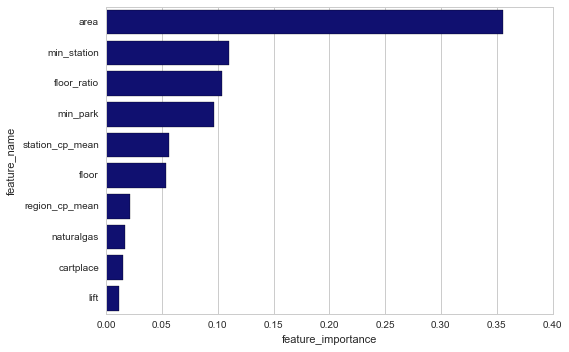

In [41]:
ax = sns.barplot(y =importance_frame_10['feature'] ,x =importance_frame_10['importances'],color = 'navy')
ax.set(xlabel = 'feature_importance',ylabel = 'feature_name')

In [67]:
test_set.groupby('min_station_name')['id'].count()

min_station_name
0             1
七張            3
三和國中          4
三重國小          1
中山           77
中山國中         73
中山國小        175
中正紀念堂        42
信義安和         89
內湖           71
公館           26
六張犁          60
劍南路          91
劍潭           87
動物園          16
北投            6
北門           43
南京三民        141
南京復興         54
南港           44
南港展覽館        37
南港軟體園區       51
古亭           92
台北101/世貿     72
台北小巨蛋        53
台北車站         33
台大醫院          2
台電大樓         69
唭哩岸          35
善導寺          59
           ... 
明德          128
景美           31
木柵           22
東湖           60
東門           92
松山           61
松山機場         17
松江南京        151
民權西路         40
永春          163
淡水            3
港墘           65
石牌          149
科技大樓         60
芝山          102
萬芳社區         35
萬芳醫院         42
萬隆           41
葫洲           37
行天宮         125
西湖           60
西門          120
象山          135
辛亥           17
關渡           23
雙連          185
頂埔            1
頂溪            3
麟光           76
龍山寺         165
Name: i

最後看一下testset的情況，疑? 怎麼會有新北市的捷運站跑出來 <br>
看看到底是什麼情況

In [68]:
test_set[test_set.min_station_name == '頂溪']

,id,room,area,houseage,living,condition,floor,layout,allfloor,kind_name,...,address_img_title,unit,address,lat,lng,loc_type,min_station,min_station_name,min_park,min_park_name
587,4674628,0,5.0,0,NaN,"icebox,washer,hotwater,four,broadband,naturalg...",13,NaN,14,雅房,...,•新大樓，好美雅房、淋浴雅房，青年公園,元/月,萬華區青年路152巷,25.020467,121.501596,GEOMETRIC_CENTER,1580.464947,頂溪,443.504239,壽德公園
3023,4712332,3,30.0,0,NaN,"cold,hotwater,landpost,cook,balcony_1,wardrobe...",4,3房2廳1衛,5,整層住家,...,近果菜市場（華中橋）公車站牌青年公園,元/月,萬華區萬大路493巷48弄16號,25.019310,121.499130,ROOFTOP,1755.733908,頂溪,422.052809,保德公園
4377,4742567,2,23.0,0,"advstore,market,park,school","cold,washer,hotwater,landpost,cook,balcony_1,bed",4,2房2廳1衛,5,整層住家,...,"採光佳,生活機能佳,近市場",元/月,萬華區富民路145巷,25.018594,121.500570,GEOMETRIC_CENTER,1592.114797,頂溪,562.084227,保德公園


原來是萬華區靠近新店溪的房子= = http://ppt.cc/un5jY <br>
台北市靠近環河的房子都會有相同的問題 <br>
就是離捷運站直線距離很短，但是實際走路的距離很長，這幾個例子來說大概差了1km左右 <br>
目前想到的解決方法是用Googlemap Distance Matrix 算出實際行走距離

In [70]:
data[(data.min_station_name == '頂埔')]

,id,room,area,price,houseage,living,condition,floor,layout,allfloor,...,address_img_title,unit,address,lat,lng,loc_type,min_station,min_station_name,min_park,min_park_name
375,4796611,0,8.0,10000.0,0,NaN,"icebox,cold,washer,hotwater,broadband,naturalg...",2,NaN,20,...,包水電網路-近中研院大套房出租,元/月,南港區林森路73巷,22.592557,120.331478,ROOFTOP,285948.679606,頂埔,293537.831475,樟新公園


當然也有錯得很離譜的資料 http://ppt.cc/YxJaf <br>
重點是test_set裡面也有發生 = = <br>
這種就....用南港展覽館取代吧?!